In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

In [2]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using Revise 

In [4]:
using BAT

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1317


In [5]:
using TypedTables

# 2-D Toy:

In [6]:
ϕ = 0:1:4

x = exp.(0.3 .* ϕ) .* cos.(ϕ)
y = exp.(0.3 .* ϕ) .* sin.(ϕ)

weights_dist = ones(length(x)) .+ rand(Uniform(-0.3, 0.3), length(x))
weights_dist = weights_dist ./ sum(weights_dist)
mixture_model = MixtureModel(MvNormal[MvNormal([x[i],y[i]], [0.04*sqrt(x[i]^2+y[i]^2), 0.04*sqrt(x[i]^2+y[i]^2) ]) for i in 1:length(x)], weights_dist);


In [7]:
prior = NamedTupleDist(a = [Uniform(-200,200), Uniform(-200,200)])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

11.982929094215963

In [8]:
# Generate IID samples 

iid_distributions = NamedTupleDist(a = mixture_model,)
samples_iid = bat_sample(iid_distributions, IIDSampling(nsamples=10^6)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


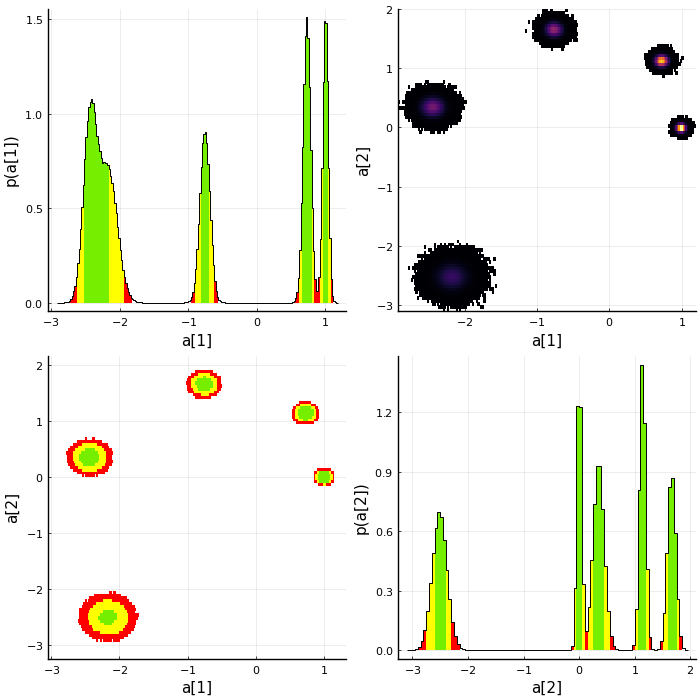

In [9]:
plot(samples_iid, size=(700,700), )

In [10]:
# Generate MCMC samples with Space Pertitioning: 

mcmc = MCMCSampling(mcalg = MetropolisHastings(), nchains=6, nsteps = 10^5, strict=false)

mcmc_exp = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 1000, nchains=20, strict=false)

algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=5, exploration_sampler=mcmc_exp, nmax_resampling=5)

output_sp = bat_sample(posterior, algorithm_1);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:43
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 20 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 20 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin 

In [11]:
samples_1 = output_sp.result;
resampled_trees = output_sp.resampled_trees;

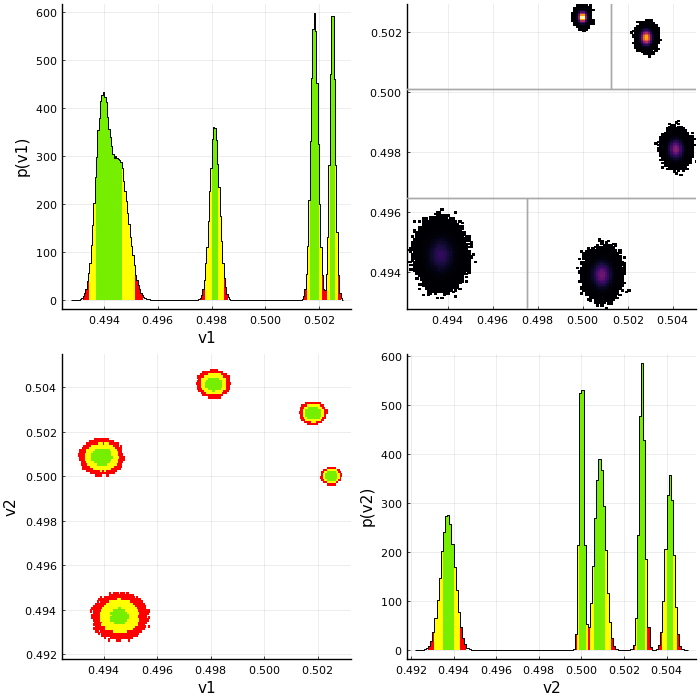

In [12]:
plot(output_sp.result_trafo, size=(700,700), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

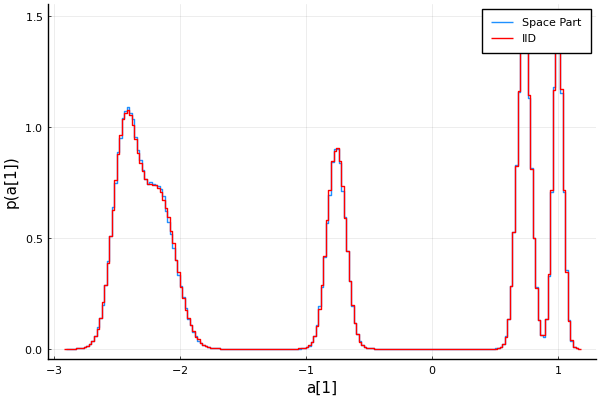

In [13]:
plot(samples_1, 1,  st = :steps, label="Space Part", marginalmode=false)
plot!(samples_iid, 1,  st = :steps, linecolor=:red, label="IID", marginalmode=false, )
# plot!(ylim=(0, 0.2))

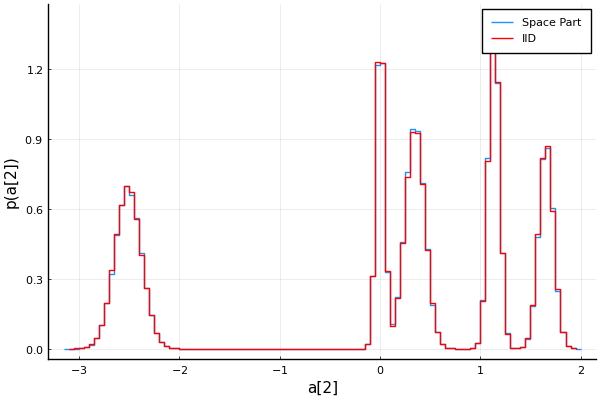

In [14]:
plot(samples_1, 2,  st = :steps, label="Space Part", marginalmode=false)
plot!(samples_iid, 2,  st = :steps, linecolor=:red, label="IID", marginalmode=false, )
# plot!(ylim=(0, 0.2))

In [15]:
# Estimated from MCMC evidence:

evid = sum(output_sp.info.density_integral)

6.279e-6 ± 1.6e-8

In [16]:
# True evidence

log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))
true_vals = exp(-log_volume)

6.250000000000004e-6